<a href="https://colab.research.google.com/github/simsekergun/ENEE691/blob/main/week05/Toy_Regularized_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\color{ForestGreen}{\text{A Toy Model for Regularized Regression}}$

As our first example, we construct a toy dataset. This dataset has only one feature $x$, and one target variable $y$. In the next step, we apply polynomial regression (without regularization) to this dataset to predict the target $y$. Finally, we add Ridge and Lasso regularizations to the regression analysis and compare the results. 

The toy dataset is generated based on the model $\boxed{y=x\,\cos x}$ for $0\leq x\leq4$. 

**Note:** Since this example is a toy example and is solely used for educational purposes, we do not split the data into train and test, and simply apply regression to the whole dataset.  

In [1]:
import numpy as np     # Import numpy
import pandas as pd    # Import pandas

np.random.seed(3)      # Fix a seed for reproducibility purposes

x = np.array([j*np.pi/180 for j in range(0, 230, 5)])   # Create a numpy array as the feature 'x'

# Create the target 'y' and add some noise chosen from a normal distribution with mean 0 and std 0.3
y = x*np.cos(x) + np.random.normal(0, 0.3, x.shape[0])  

# Construct a dataframe with two columns 'x' and 'y'
df = pd.DataFrame(np.column_stack([x, y]), columns=['x', 'y'])

df.head()              # Display the first few rows of 'df'

,x,y
0,0.000000,0.536589
1,0.087266,0.217887
2,0.174533,0.200831
3,0.261799,-0.306169
4,0.349066,0.244798


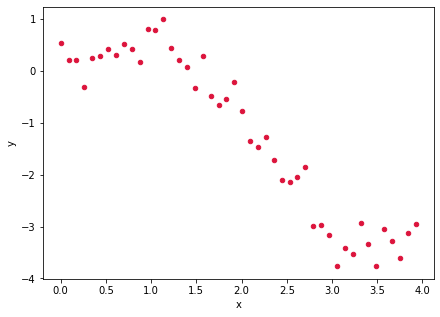

In [2]:
import matplotlib.pyplot as plt    # Import matplotlib 
 
df.plot.scatter(x='x', y='y', color='crimson', figsize=(7,5))   # Scatter plot of '(x, y)'
plt.show()

In [3]:
# We now need to construct powers of 'x' to be able to perform polynomial regression

power_col = ['x^%d' %(i) for i in range(2, 11)]    # Create name for the power columns
print(power_col)

['x^2', 'x^3', 'x^4', 'x^5', 'x^6', 'x^7', 'x^8', 'x^9', 'x^10']


In [4]:
for col in power_col:
    power = int(col.split('^')[1])   # Extract 'power'
    df[col] = df['x']**power         # Construct the column 'x^power' 
    
df = df[['x'] + power_col + ['y']]   # Change the order of columns (put 'y' at the end)

In [5]:
df.head()     # Display dataframe

,x,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.536589
1,0.087266,0.007615,0.000665,0.000058,0.000005,4.416561e-07,3.854177e-08,3.363404e-09,2.935123e-10,2.561378e-11,0.217887
2,0.174533,0.030462,0.005317,0.000928,0.000162,2.826599e-05,4.933346e-06,8.610313e-07,1.502783e-07,2.622851e-08,0.200831
3,0.261799,0.068539,0.017943,0.004698,0.001230,3.219673e-04,8.429084e-05,2.206729e-05,5.777203e-06,1.512468e-06,-0.306169
4,0.349066,0.121847,0.042533,0.014847,0.005182,1.809023e-03,6.314683e-04,2.204240e-04,7.694250e-05,2.685800e-05,0.244798


## $\color{ForestGreen}{\text{Linear Regression without Regularization}}$

We define a function $\textsf{do_linear_reg}$ that performs regression of above dataset $\textsf{df}$ at a specified degree $\textsf{power}$. 

In [6]:
from sklearn.linear_model import LinearRegression  # Import 'LinearRegression' from sklearn

In [7]:
def do_linear_reg(df, power):     # Defining a function to do polynomial regression on 'df'
    cols = ['x']
    if power > 1:
        cols += ['x^%d' %(j) for j in range(2, power+1)]  # Considering colmuns up to 'power'+1
    
    X = df[cols].values     # Features of regression
    y = df['y'].values      # Target of regression
    
    lin_reg = LinearRegression()  # Instantiate 'LinearRegression'
    lin_reg.fit(X, y)             # Fit the data
    
    r2_score = lin_reg.score(X, y)   # Calculate R^2 score
    coefs = lin_reg.coef_            # Calculate the coefficients/weights of regression
    intercept = lin_reg.intercept_   # Calculate the intercept/bias term
    
    y_pred = lin_reg.predict(X)      # Predict the target
    df['yhat'] = y_pred              # Add prediction to 'df'
    plt.plot(df['x'], df['yhat'], color='green')       # Plot the prediction
    plt.plot(df['x'], df['y'], '.', color='crimson')   # Plot the truth target
    plt.gcf().set_size_inches(8, 5)
    plt.show()
    
    return r2_score, coefs, intercept    # Spit out R^2-score, weights, bias term

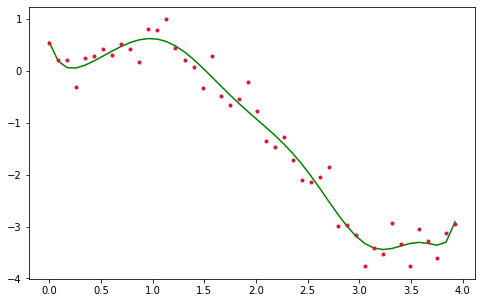

(0.9730499031904771,
 array([-6.29571185e+00,  2.89348931e+01, -6.71520801e+01,  1.01133427e+02,
        -9.94047993e+01,  6.19916573e+01, -2.40840194e+01,  5.62586282e+00,
        -7.21606449e-01,  3.90059952e-02]),
 0.5551844911345172)

In [8]:
do_linear_reg(df, 10)  # Perform regression up to power 11

## $\color{ForestGreen}{\text{Ridge Regression}}$

We define a function $\textsf{do_ridge_reg}$ that performs Ridge regression of above dataset $\textsf{df}$ at a specified degree $\textsf{power}$. 

In [9]:
from sklearn.linear_model import Ridge   # Import 'Ridge' from sklearn

In [10]:
# Defining a function to do Ridge polynomial regression on 'df' with penalty factor 'a'
def do_ridge_reg(df, power, a):   
    cols = ['x']
    if power > 1:
        cols += ['x^%d' %(j) for j in range(2, power+1)]  # Considering colmuns up to 'power'+1
    
    X = df[cols].values    # Features of regression
    y = df['y'].values     # Target of regression
    
    ridge = Ridge(alpha=a, max_iter=10000)  # Instantiate Ridge regression with penalty strength 'a'
    ridge.fit(X, y)                        # Fit the data
    
    r2_score = ridge.score(X, y)           # Calculate R^2 score
    coefs = ridge.coef_                    # Calculate the coefficients/weights of regression
    intercept = ridge.intercept_           # Calculate the intercept/bias term
    
    y_pred = ridge.predict(X)              # Predict the target
    df['yhat'] = y_pred                    # Add prediction to 'df'
    plt.plot(df['x'], df['yhat'], color='green')      # Plot the prediction
    plt.plot(df['x'], df['y'], '.', color='crimson')  # Plot the truth target
    plt.gcf().set_size_inches(8, 5)
    plt.show()
    
    return r2_score, coefs, intercept      # Spit out R^2-score, weights, bias term

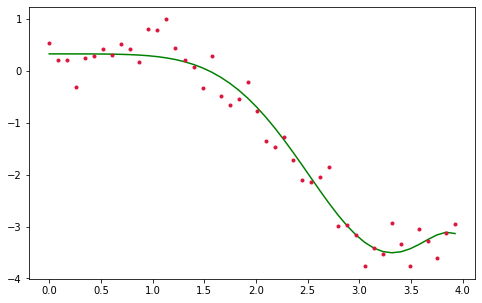

(0.9608158063932598,
 array([-0.00055512, -0.00217727, -0.0049782 , -0.0089425 , -0.01309923,
        -0.01415432, -0.00644623,  0.00890727, -0.00214406,  0.00014723]),
 0.3272150689160278)

In [11]:
# Perform Ridge regression up to power 11 with penalty 100

do_ridge_reg(df, 10, 10e2)  

## $\color{ForestGreen}{\text{Lasso Regression}}$

We define a function $\textsf{do_lasso_reg}$ that performs Lasso regression of above dataset $\textsf{df}$ at a specified degree $\textsf{power}$.

In [12]:
from sklearn.linear_model import Lasso    # Import 'Lasso' from sklearn

In [13]:
# Defining a function to do Lasso polynomial regression on 'df' with penalty factor 'a'
def do_lasso_reg(df, power, a):
    cols = ['x']
    if power > 1:
        cols += ['x^%d' %(j) for j in range(2, power+1)]   # Considering colmuns up to 'power'+1
    
    X = df[cols].values       # Features of regression
    y = df['y'].values        # Target of regression
    
    # Instantiate Lasso regression with penalty strength 'a'
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X, y)                  # Fit the data
    
    r2_score = lasso.score(X, y)     # Calculate R^2 score
    coefs = lasso.coef_              # Calculate the coefficients/weights of regression
    intercept = lasso.intercept_     # Calculate the intercept/bias term
    
    y_pred = lasso.predict(X)        # Predict the target
    df['yhat'] = y_pred              # Add prediction to 'df'
    plt.plot(df['x'], df['yhat'], color='green')         # Plot the prediction
    plt.plot(df['x'], df['y'], '.', color='crimson')     # Plot the truth target
    plt.gcf().set_size_inches(8, 5)
    plt.show()
    
    return r2_score, coefs, intercept     # Spit out R^2-score, weights, bias term

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e+00, tolerance: 1.137e-02
  model = cd_fast.enet_coordinate_descent(


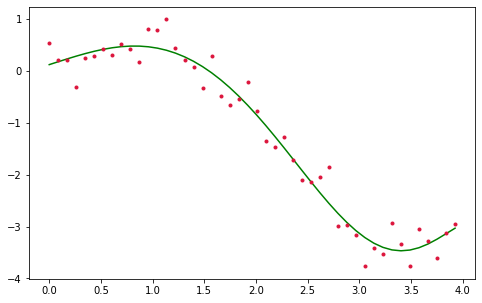

(0.9663103510308396,
 array([ 6.38670727e-01,  4.72492743e-02, -3.67961331e-01,  3.45373177e-03,
         9.64487673e-03,  1.98312411e-03,  2.88229435e-04,  1.69150934e-05,
        -8.70935570e-06, -5.02165428e-06]),
 0.12006575464332947)

In [14]:
# Perform Lasso regression up to power 11 with penalty 0.001

do_lasso_reg(df, 10, 0.001)  

Note that many of the weights (regression coefficients) are **exactly 0** (when we enforce normalization)! So, Lasso regression can be employed as a **feature selection tool**.

## $\color{ForestGreen}{\text{Elastic Net Regression}}$

We define a function $\textsf{do_elastic_reg}$ that performs Elastic Net regression of above dataset $\textsf{df}$ at a specified degree $\textsf{power}$. 

In [15]:
from sklearn.linear_model import ElasticNet    # Import 'ElasticNet' from sklearn

In [16]:
# Defining a function to do elastic net polynomial regression on 'df' with penalty factor 'a' and l1_ratio 'b'
def do_elastic_reg(df, power, a, b):
    cols = ['x']
    if power > 1:
        cols += ['x^%d' %(j) for j in range(2, power+1)]   # Considering colmuns up to 'power'+1
    
    X = df[cols].values       # Features of regression
    y = df['y'].values        # Target of regression
    
    # Instantiate Elastic Net regression with penalty strength 'a' and 'l1_ratio=b' 
    elastic = ElasticNet(alpha=a, l1_ratio=b)
    elastic.fit(X, y)                  # Fit the data
    
    r2_score = elastic.score(X, y)     # Calculate R^2 score
    coefs = elastic.coef_              # Calculate the coefficients/weights of regression
    intercept = elastic.intercept_     # Calculate the intercept/bias term
    
    y_pred = elastic.predict(X)        # Predict the target
    df['yhat'] = y_pred                # Add prediction to 'df'
    plt.plot(df['x'], df['yhat'], color='green')         # Plot the prediction
    plt.plot(df['x'], df['y'], '.', color='crimson')     # Plot the truth target
    plt.gcf().set_size_inches(8, 5)
    plt.show()
    
    return r2_score, coefs, intercept     # Spit out R^2-score, weights, bias term

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e+00, tolerance: 1.137e-02
  model = cd_fast.enet_coordinate_descent(


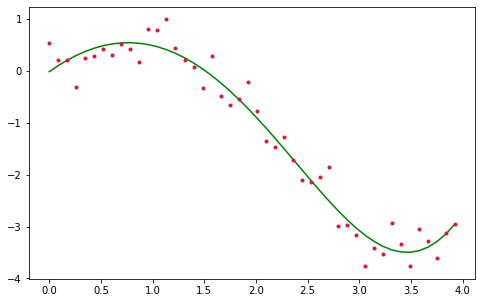

(0.964530915523386,
 array([ 1.42588415e+00, -8.53025656e-01, -8.15638936e-02,  8.81174200e-03,
         4.03001733e-03,  8.61105022e-04,  1.34348143e-04,  1.12953249e-05,
        -2.37970223e-06, -1.71985185e-06]),
 -0.01638949770903486)

In [17]:
# Perform Lasso regression up to power 11 with penalty 0.001 and l1_ratio 0.7

do_elastic_reg(df, 10, 0.001, 0.7) 

As observed above, fewer number of weights are exactly zero when compared with Lasso case. The general sentiment is that the Elastic Net regression is in between of Ridge and Lasso regressions.